# Тестирование классификатора эмоций

В этом ноутбуке описано тестирование модели, а также подготовка файла для Kaggle

In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

import emo_utils as utils

import pandas as pd
import numpy as np
import os

import random

In [2]:
# флаг использования Google drive как хранилища данных
USE_GOOGLE_DRIVE = False

#Корневая папка проекта
root_dir = ''

In [3]:
#Подключаем google drive, если код будет выполняться в Colab
if USE_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Projects/EmoDetector'

#if

In [4]:
#Получаем пути к директориям и файлам проекта

paths = utils.get_paths()

print (paths)

{'data_dir': 'data', 'model_dir': 'model', 'train_data_dir': 'data/train', 'test_data_dir': 'data/test_kaggle', 'class_names_path': 'data/class_names.txt', 'best_checkpoint_path': 'model/emo_classificator_best'}


In [5]:
#загрузим названия эмоций (классов)
emo_classes_names = []
with open(paths['class_names_path'], 'r') as f:
    emo_classes_names = f.read().split(',')
    
emo_classes_names

['anger',
 'contempt',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise',
 'uncertain']

In [10]:
# Параметры

#тип базовой модели
BASE_MODEL = 'xception'
#Размер изображения, с кот. работает модель
IMAGE_SIZE = 299

# функция для предообработки изображения
preprocess_input = None
if BASE_MODEL == 'resnet50':
    preprocess_input = resnet50_preprocess_input
elif BASE_MODEL == 'vgg16':
    preprocess_input = vgg16_preprocess_input
elif BASE_MODEL == 'xception':
    preprocess_input = xception_preprocess_input

#Путь к сохраненной модели
model_path = paths['model_dir'] + '/emo_classificator_best_201223071547_xception_e10_acc34.h5'

In [7]:
# Загрузим модель
model_emo_classificator = tf.keras.models.load_model(model_path)

In [51]:
#Соберем пути до изображений и индексы их эмоций

folder = []    
for i in os.walk(paths['train_data_dir']):
    folder.append(i)

images_paths = []
images_labels = []
for i in folder:
    for j in i[2]:
        images_paths.append(i[0]+'/'+j)
        images_labels.append(emo_classes_names.index(i[0].split('/')[-1]))    
    #for

# выберем картинки для проверки
sample_cnt = 16

sample_img_paths = []
sample_img_labels = []
for i in range (sample_cnt):
    index = random.choice(range(0, len(images_paths)))
    sample_img_paths.append (images_paths[index])
    sample_img_labels.append (images_labels[index])
    
#for

print (sample_img_paths)
print (sample_img_labels)

['data/train/surprise/536.jpg', 'data/train/neutral/4623.jpg', 'data/train/happy/5730.jpg', 'data/train/happy/1584.jpg', 'data/train/happy/395.jpg', 'data/train/anger/5470.jpg', 'data/train/neutral/553.jpg', 'data/train/anger/5538.jpg', 'data/train/anger/777.jpg', 'data/train/uncertain/5737.jpg', 'data/train/fear/1293.jpg', 'data/train/anger/1805.jpg', 'data/train/anger/4305.jpg', 'data/train/anger/519.jpg', 'data/train/neutral/2018.jpg', 'data/train/anger/525.jpg']
[7, 5, 4, 4, 4, 0, 5, 0, 0, 8, 3, 0, 0, 0, 5, 0]


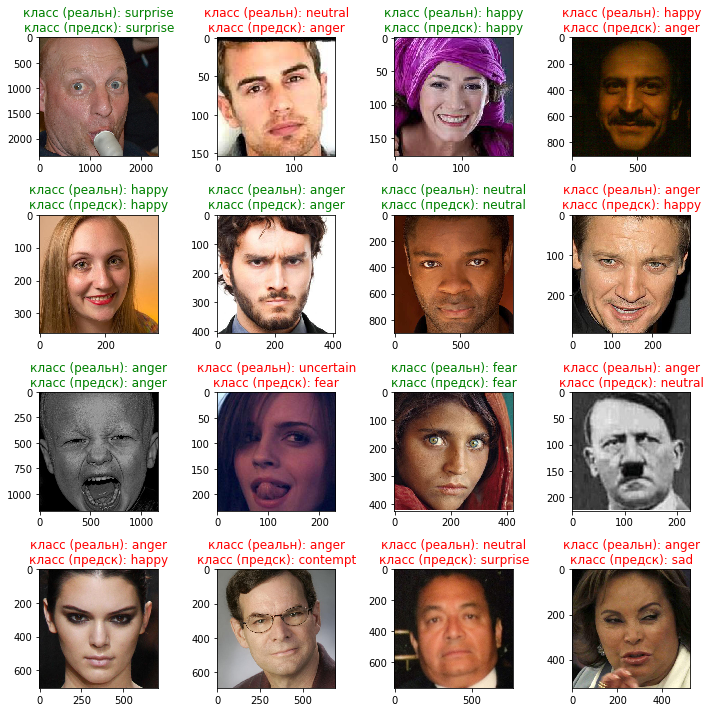

In [52]:
#Тест модели

utils.test_model_prediction (p_model = model_emo_classificator,
                             p_img_paths = sample_img_paths,
                             p_img_emo_idxs = sample_img_labels,
                             p_img_target_size = (IMAGE_SIZE, IMAGE_SIZE),
                             preprocess_func = preprocess_input,
                             p_emo_classes_names = emo_classes_names)

## Получение файла для проверки модели на Kaggle

In [8]:
#Загрузим перечень картинок для теста

test_images = []

for root, dirs, files in os.walk(paths['test_data_dir']):
    test_images = files
    break

#for
   
print (test_images)

['3994.jpg', '389.jpg', '2135.jpg', '691.jpg', '1910.jpg', '4607.jpg', '2572.jpg', '4091.jpg', '3305.jpg', '2579.jpg', '1005.jpg', '2922.jpg', '426.jpg', '4590.jpg', '514.jpg', '873.jpg', '4174.jpg', '720.jpg', '1513.jpg', '835.jpg', '1353.jpg', '4504.jpg', '1403.jpg', '3937.jpg', '494.jpg', '951.jpg', '4918.jpg', '133.jpg', '1491.jpg', '166.jpg', '436.jpg', '2040.jpg', '2717.jpg', '1758.jpg', '3762.jpg', '4909.jpg', '3503.jpg', '2807.jpg', '4678.jpg', '2306.jpg', '711.jpg', '3161.jpg', '3586.jpg', '3912.jpg', '3398.jpg', '653.jpg', '2700.jpg', '4007.jpg', '3596.jpg', '3879.jpg', '414.jpg', '4490.jpg', '652.jpg', '3626.jpg', '250.jpg', '1357.jpg', '3348.jpg', '395.jpg', '2702.jpg', '4764.jpg', '3814.jpg', '2798.jpg', '214.jpg', '713.jpg', '4813.jpg', '1749.jpg', '392.jpg', '2772.jpg', '4554.jpg', '4720.jpg', '4325.jpg', '4827.jpg', '4611.jpg', '3263.jpg', '1903.jpg', '461.jpg', '908.jpg', '479.jpg', '958.jpg', '3014.jpg', '441.jpg', '1284.jpg', '4219.jpg', '3130.jpg', '633.jpg', '3084.

In [11]:
#Формируем файл для проверки на kaggle

target_img_size = (IMAGE_SIZE, IMAGE_SIZE)

df = pd.DataFrame(columns = ['image_path', 'emotion', 'image_id'])

for img_file in test_images:

    preprocessed_img = utils.preprocess_image(paths['test_data_dir']+'/'+img_file, 
                                              target_img_size, 
                                              preprocess_input)
    #получим предсказания
    predictions = model_emo_classificator.predict(preprocessed_img)
    
    file_name, _ = os.path.splitext(img_file)
    image_id = int(file_name)
    
    df = df.append ({'image_path': img_file, 
                     'emotion': emo_classes_names[np.argmax(predictions)], 
                     'image_id': image_id}, ignore_index=True) 
#for
    
df = df.sort_values('image_id')
df = df.drop('image_id', axis=1)

df.to_csv(paths['data_dir']+'/' + os.path.basename(model_path).replace('.h5','.csv'), index = False)

df

,image_path,emotion
2131,0.jpg,sad
2594,1.jpg,neutral
1784,2.jpg,uncertain
2728,3.jpg,happy
1282,4.jpg,neutral
...,...,...
4637,4995.jpg,surprise
1701,4996.jpg,anger
4592,4997.jpg,neutral
3400,4998.jpg,anger
